<a href="https://colab.research.google.com/github/lulujingyi/Gate-Detection/blob/master/Gate_Detection_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**0. Prepare**

Check the cuda version and install the corresponding mxnet. Here, the mxnet 10.1 is installed.

Upload images and masks to google drive manually. Path: '/content/gdrive/My Drive/MAV/data'.

In [1]:
!pip install mxnet-cu101

     |████████████████████████████████| 710.5MB 27kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


**1. Import Modules**

In [0]:
from mxnet import autograd, gluon, image, nd, init
from mxnet.gluon import data as gdata, utils as gutils, loss as gloss, nn
from mxnet.gluon.model_zoo import vision as models
import mxnet as mx
import time
import os
import sys
import tarfile
from google.colab import drive
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import cv2
import csv

**2.Organize Data**

Mount data from google drive. Categorize data into image and mask and sort them in order. There are 308 images + 308 masks, 275 images and 275 masks have a size of 360*360. Discard those with non standard size. Set the first 250 as the training set, the rest as the test set.

In [3]:
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive/'
path = '/content/gdrive/My Drive/MAV/'
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
 AE1110II_space_slides_5-6_v16.1.untilsheet25.pdf
'Chapter 12 week 1(1).pptx'
'Colab Notebooks'
'Course Outline V1 2016-2017 (1).docx'
'Deep Learning'
'Deep Learning Presentation.pptx'
'Deep Learning Project'
 Hyperloop.gslides
 image.jpg
'Intro materials   chemical bonds  2016-2017 (1).ppt'
'Lecture 2  Dynamic loads 1617.pdf'
'link buget.gsheet'
 littlewhite.jpg
 MAV
'Operations Assigment.gsheet'
'tudelft stramien 16 9.gslides'
'Untitled Diagram.drawio'
'Unt

Get the list of file names

In [4]:
data_path = path + 'data/'
folder = os.listdir(data_path)
image = []
mask = []

for f in folder:
  if f[0] == 'i':
    image.append(f)
  else:
    mask.append(f)
image.sort(key=lambda x:int(x[4:-4])) 
mask.sort(key=lambda x:int(x[5:-4]))



print('There are ',len(mask),' images in total.')

train_size = 280
image_train = image[0:train_size]
mask_train = mask[0:train_size]
image_test = image[train_size:len(image)]
mask_test = mask[train_size:len(mask)]
print(len(image_train),' are set to the training set and ',len(mask_test),' are set to the test set')

There are  308  images in total.
280  are set to the training set and  28  are set to the test set


Read data. Images are features, masks are labels. Opencv reads images as BGR. Convert features from BGR to RGB. Crop training image and label into two segment with a size of 360*240

In [0]:
def read_data(root=data_path, is_train=True):
  if is_train:
    features = [None]*len(image_train)*2
    labels = [None]*len(image_train)*2
    crop = 240
    for i in range(len(image_train)):
      img = cv2.imread(data_path+image_train[i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      shape = np.shape(img)
      width = shape[1]
      img1 = img[0:360,0:crop]
      img2 = img[0:360,width-crop:width]
      features[2*i] = nd.array(img1) #Convert nparray to mx.NDArray
      features[2*i+1] = nd.array(img2)
      lab = cv2.imread(data_path+mask_train[i])
      lab1 = lab[0:360,0:crop]
      lab2 = lab[0:360,width-crop:width]
      labels[2*i] = nd.array(lab1)
      labels[2*i+1] = nd.array(lab2)
  else:
    features = [None]*len(image_test)
    labels = [None]*len(image_test)
    for i in range(len(image_test)):
      img = cv2.imread(data_path+image_test[i])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      features[i] = nd.array(img)
      lab = cv2.imread(data_path+mask_test[i])
      labels[i] = nd.array(lab)
  return features,labels

train_features,train_labels = read_data(data_path,True)

Define a function to get the label of each pixel of masks. 0 for background and 1 for gate.

Define a function to normalize the RGB value of features.

In [0]:
Gate_Colormap = [[0,0,0],[255,255,255]]
colormap2label = nd.zeros(256**3)
for i,colormap in enumerate(Gate_Colormap):
  colormap2label[(colormap[0]*256+colormap[1])*256+colormap[2]]=i
 

def label_indices(colormap,colormap2label):
  colormap = colormap.astype('int32')
  idx = ((colormap[:,:,0]*256+colormap[:,:,1])*256+colormap[:,:,2])
  return colormap2label[idx]

def normalize_image(img):
  rgb_mean = nd.array([0.485,0.456,0.406])
  rgb_std = nd.array([0.229,0.224,0.225])
  return (img.astype('float32')/255-rgb_mean)/rgb_std

**3.Load Data**

In [7]:
class GateDataset(gdata.Dataset):
  def __init__(self, is_train, data_path, colormap2label):
    features,labels = read_data(root=data_path,is_train=is_train)
    self.features = features
    self.labels = labels
    self.colormap2label = colormap2label
    print('read '+str(len(self.features))+' examples')
  def __getitem__(self,idx):
    img = self.features[idx]
    feature = normalize_image(img)
    label = self.labels[idx]
    return (feature.transpose((2,0,1)),label_indices(label,self.colormap2label))
  def __len__(self):
    return len(self.features)

train = GateDataset(True,data_path,colormap2label)

read 560 examples


In [8]:
batch_size = 5
train_iter = gdata.DataLoader(train,batch_size,shuffle=True)
for X,Y in train_iter:
  print('Shape of the image is ', X.shape)
  print('Shape of the label is ', Y.shape)
  break

Shape of the image is  (5, 3, 360, 240)
Shape of the label is  (5, 360, 240)


**4.Build FNN Model**

Replace the last four layers of the Resnet18 by a convolutional layer and a transposed convolutional layer.

In [9]:
pretrained_net=models.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
  net.add(layer)

x = nd.random.uniform(shape=(1,3,360,240))
print('The shape becomes ', net(x).shape, ' before the transpose layer.')

The shape becomes  (1, 512, 12, 8)  before the transpose layer.


The added convolutional layer makes the output channel number equal to the number of classes. The transposed convolutional converts the shape back to the original size.

In [0]:
num_classes = 2
net.add(nn.Conv2D(num_classes,kernel_size=1),
        nn.Conv2DTranspose(num_classes,kernel_size = 60,padding = 15,strides = 30))

In [0]:
def bilinear_kernel(in_channels,out_channels,kernel_size):
  factor = (kernel_size+1)//2
  if kernel_size % 2 == 1:
    center = factor-1
  else:
    center = factor-0.5
  og = np.ogrid[:kernel_size, :kernel_size]
  filt = (1-abs(og[0]-center)/factor)*(1-abs(og[1]-center)/factor)
  weight = np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype='float32')
  weight[range(in_channels),range(out_channels),:,:] = filt
  return nd.array(weight)

In [0]:
net[-1].initialize(init.Constant(bilinear_kernel(num_classes,num_classes,60)))
net[-2].initialize(init=init.Xavier())

In [13]:
test = GateDataset(False,data_path,colormap2label)

test_iter = gdata.DataLoader(test,batch_size)
for X,Y in train_iter:
  print(X.shape)
  print(Y.shape)
  break

read 28 examples
(5, 3, 360, 240)
(5, 360, 240)


**5.Design Training Loop**

Define a function to use all GPUs available.

Define a function to compute the train accuracy and test accuracy per epoch.

In [0]:
def try_all_gpus():
  ctxes = []
  try:
    for i in range(16):
      ctx = mx.gpu(i)
      _ = nd.array([0], ctx = ctx)
      ctxes.append(ctx)
  except mx.base.MXNetError:
    pass
  if not ctxes:
    ctxes = [mx.cpu()]
  return ctxes

def _get_batch(batch,ctx):
  features,labels = batch
  if labels.dtype != features.dtype:
    labels = labels.astype(features.dtype)
  return (gutils.split_and_load(features,ctx),
          gutils.split_and_load(labels,ctx),features.shape[0])
  
def evaluate_accuracy(data_iter,net,ctx=[mx.cpu()]):
  if isinstance(ctx, mx.Context):
    ctx = [ctx]
  acc_sum, n=nd.array([0]),0
  for batch in data_iter:
    features,labels,_=_get_batch(batch,ctx)
    for X, y in zip(features, labels):
      y = y.astype('float32')
      acc_sum += (net(X).argmax(axis=1)==y).sum().copyto(mx.cpu())
      n +=y.size
    acc_sum.wait_to_read()
  return acc_sum.asscalar()/n

In [0]:
def train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs):
  print('training on', ctx)
  if isinstance(ctx,mx.Context):
    ctx = [ctx]
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n,m,start = 0.0, 0.0, 0, 0,time.time()
    for i, batch in enumerate(train_iter):
      Xs,ys,batch_size = _get_batch(batch,ctx)
      with autograd.record():
        y_hats = [net(X) for X in Xs]
        ls = [loss(y_hat,y) for y_hat, y in zip(y_hats,ys)]
      for l in ls:
        l.backward()
      trainer.step(batch_size)
      train_l_sum += sum([l.sum().asscalar() for l in ls])
      n += sum([l.size for l in ls])
      train_acc_sum += sum([(y_hat.argmax(axis=1)==y).sum().asscalar() for y_hat,y in zip(y_hats,ys)])
      m += sum([y.size for y in ys])
    test_acc = evaluate_accuracy(test_iter,net,ctx)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
          % (epoch+1, train_l_sum/n, train_acc_sum/m, test_acc, time.time()-start))

**6.Train**

In [16]:
ctx = try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.1,'wd': 1e-3})
train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs=8)

training on [gpu(0)]
epoch 1, loss 0.1936, train acc 0.926, test acc 0.904, time 15.8 sec
epoch 2, loss 0.1117, train acc 0.947, test acc 0.941, time 13.4 sec
epoch 3, loss 0.1032, train acc 0.951, test acc 0.942, time 13.4 sec
epoch 4, loss 0.0976, train acc 0.954, test acc 0.941, time 13.3 sec
epoch 5, loss 0.0944, train acc 0.956, test acc 0.943, time 13.3 sec
epoch 6, loss 0.0916, train acc 0.957, test acc 0.951, time 13.5 sec
epoch 7, loss 0.0898, train acc 0.958, test acc 0.950, time 13.3 sec
epoch 8, loss 0.0877, train acc 0.959, test acc 0.952, time 13.3 sec


**7.Predict on Testset**



Define a function to get the prediction and convert it from label to RGB

In [0]:
def predict(img):
  X = normalize_image(img)
  X = X.transpose((2,0,1)).expand_dims(axis=0)
  pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
  return pred.reshape((pred.shape[1],pred.shape[2]))

def label2image(pred):
  colormap = nd.array(Gate_Colormap,ctx=ctx[0],dtype='uint8')
  X = pred.astype('int32')
  return colormap[X,:]

0.058281898498535156


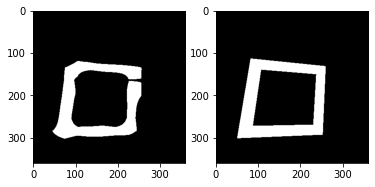

In [18]:
test_images, test_labels = read_data(data_path,False)
x = test_images[0]
y = test_labels[0]
start_time = time.time()
prediction = predict(x)
print(time.time()-start_time)
pred = label2image(predict(x))
plt.subplot(121)
plt.imshow(pred.asnumpy())
plt.subplot(122)
plt.imshow(y.asnumpy())

Save prediction results to folder: predict

In [0]:
path_output = path+'predict_data_aug/'
os.makedirs(path_output)

for i in range(len(test_images)):
  x = test_images[i]
  pred = label2image(predict(x))
  pred = pred.asnumpy()
  matplotlib.image.imsave(path_output+'predictda'+str(i)+'.png', pred)

**8. Plot ROC**

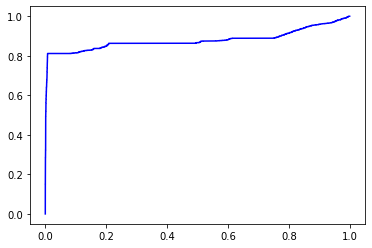

In [19]:
def ROC(i):
  x = test_images[i]
  y = test_labels[i]
  pred = label2image(predict(x))
  pred = label_indices(pred,colormap2label)
  pred = pred.asnumpy()
  pred = pred.flatten()

  truth = label_indices(y,colormap2label)
  truth = truth.asnumpy()
  truth = truth.flatten()

  n_values = len(pred)
  totalP = sum(truth)
  totalN = n_values - totalP

  inds = np.argsort(pred)
  s_pred = pred[inds]
  s_truth = truth[inds]

  TP = np.zeros([n_values, 1]);
  FP = np.zeros([n_values, 1]);

  for e in range(n_values):
    P = np.sum(s_truth[e:]);
    TP[e] = P / totalP;
    FP[e] = (len(s_truth[e:]) - P) / totalN;
  return TP,FP

TP,FP=ROC(3)
plt.figure();
plt.plot(FP, TP, 'b');

Save ROC curves into a folder: ROC

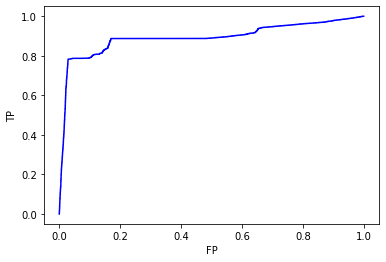

In [20]:
path_roc = path+'roc_data_aug/'
os.makedirs(path_roc)

for i in range(len(test_images)):
  TP,FP=ROC(i)
  plt.cla()
  plt.plot(FP, TP, 'b');
  plt.xlabel('FP');
  plt.ylabel('TP');
  plt.savefig(path_roc+'rocda'+str(i)+'.png')